# Concrete Strength Prediction using Rsndom Forest

This notebook analyzes concrete strength dats and builds a Random Forest model to predict concrete strength based pn various components

## 1. Import Required Libraries

Import pandas, numpy, matplotlib, seaborn and sklearn libraries for data manipulation, visualization, and machine learning

In [47]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings('ignore')

# set style for plots
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Dataset

Use pandas to load the training and test datasets from CSV files.

In [48]:
# Load the datasets
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
sample_submssion = pd.read_csv('datasets/sample_submission.csv')

print(f"Trainign data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission selection shape: {sample_submssion.shape}")

# Display first few rows of training data
print("\nFirst 5 rows of training data:")
train_df.head()

Trainign data shape: (5407, 10)
Test data shape: (3605, 9)
Sample submission selection shape: (3605, 2)

First 5 rows of training data:


,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


## 5. Data Preprocessing

Handle missing values, encode categorical variables, and preprare features for the Random Forest model.

In [50]:
# for component in ['BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent']:
#     train_df.loc[train_df[component] != 0, f'{component}_used'] = 1
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].fillna(0)
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].astype(int)

#     test_df.loc[test_df[component] != 0, f'{component}_used'] = 1
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].fillna(0)
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].astype(int)

In [51]:
# Check for missing values again
print("Missng values in training data:")
print(train_df.isnull().sum())
print('\nMissing values in test data:')
print(test_df.isnull().sum())

# Since there are no missing values, we proceed to feature selection
# Preprare features and target
X = train_df.drop(['id', 'Strength'], axis=1)
y = train_df['Strength']
X_test = test_df.drop(['id'], axis=1)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

print("\nFeature columsns:")
print(X.columns.tolist())

Missng values in training data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

Missing values in test data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64

Feature matrix shape: (5407, 8)
Target vector shape: (5407,)
Test feature matrix shape: (3605, 8)

Feature columsns:
['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


In [52]:
# Random Forest doesn't require feature scaling, but we'll keep the option
# For Random Forest, we'll use the original features without scaling
print("Random Forest can work with original features without scaling.")
print("Using original features for Random Forest model.")

# Keep the original features for Random Forest
X_final = X.copy()
X_test_final = X_test.copy()

print(f"\ntraining features shape: {X_final.shape}")
print(f"Test features shape: {X_test.shape}")

# Display first few rows of features
print("\nfirst 5 rows of features:")
X_final.head()

Random Forest can work with original features without scaling.
Using original features for Random Forest model.

training features shape: (5407, 8)
Test features shape: (3605, 8)

first 5 rows of features:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90


## 6. Feature Engineering

In [53]:
# Feature engineering completed in the previous section
# This cell can be used for additional feature engineering if needed
print("Feature engineering section - completed above")

Feature engineering section - completed above


## 7. Split Data into Train and Test Sets

Separate features and target variables, and split the training data for model validation

In [54]:
# Creating feature engineering for both train and test sets
print("Starting feature engineering...")
print(f"Original feature columns: {X.columns.tolist()}")

# Create engineered features for training data
X_engineered = X.copy()

# Ratio features - using correct column names
X_engineered['CementToWater'] = X['CementComponent'] / (X['WaterComponent'] + 1e-8)
X_engineered['CementToAge'] = X['CementComponent'] / (X['AgeInDays'] + 1)  # Fixed to 'AgeInDays'
X_engineered['TotalBinder'] = X['CementComponent'] + X['BlastFurnaceSlag'] + X['FlyAshComponent']
X_engineered['WaterToBinder'] = X['WaterComponent'] / (X_engineered['TotalBinder'] + 1e-8)

# Polynomial features for key components - using correct column names
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
key_features = ['CementComponent', 'WaterComponent', 'AgeInDays']  # Fixed to 'AgeInDays'
poly_features = poly.fit_transform(X[key_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(key_features))
X_engineered = pd.concat([X_engineered, poly_df], axis=1)

# Apply same feature engineering to test data
X_test_engineered = X_test.copy()
X_test_engineered['CementToWater'] = X_test['CementComponent'] / (X_test['WaterComponent'] + 1e-8)
X_test_engineered['CementToAge'] = X_test['CementComponent'] / (X_test['AgeInDays'] + 1)  # Fixed to 'AgeInDays'
X_test_engineered['TotalBinder'] = X_test['CementComponent'] + X_test['BlastFurnaceSlag'] + X_test['FlyAshComponent']
X_test_engineered['WaterToBinder'] = X_test['WaterComponent'] / (X_test_engineered['TotalBinder'] + 1e-8)

# Apply polynomial features to test data
poly_features_test = poly.transform(X_test[key_features])  # Use transform, not fit_transform
poly_df_test = pd.DataFrame(poly_features_test, columns=poly.get_feature_names_out(key_features))
X_test_engineered = pd.concat([X_test_engineered, poly_df_test], axis=1)

print(f"Engineered training features shape: {X_engineered.shape}")
print(f"Engineered test features shape: {X_test_engineered.shape}")
print(f"New feature columns added: {[col for col in X_engineered.columns if col not in X.columns]}")

# Update X_final and X_test_final to use engineered features
X_final = X_engineered.copy()
X_test_final = X_test_engineered.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

print(f"\nTraining set percentage: {len(X_train) / len(X_final) * 100:.2f}%")
print(f"Validation set percentage: {len(X_val) / len(X_final) * 100:.2f}%")

Starting feature engineering...
Original feature columns: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']
Engineered training features shape: (5407, 21)
Engineered test features shape: (3605, 21)
New feature columns added: ['CementToWater', 'CementToAge', 'TotalBinder', 'WaterToBinder', 'CementComponent^2', 'CementComponent WaterComponent', 'CementComponent AgeInDays', 'WaterComponent^2', 'WaterComponent AgeInDays', 'AgeInDays^2']
Training set shape: (4325, 21)
Validation set shape: (1082, 21)
Training target shape: (4325,)
Validation target shape: (1082,)

Training set percentage: 79.99%
Validation set percentage: 20.01%


## 7. Train Random Forest Model

Create and train a Random Forest model using sklearn, and evaluate its performance on validation data

In [55]:
# defining parameter grid for Random Forest
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV for efficiency
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV to find best parameters
print("Training Random Forest with hyperparameter optimization...")
rf_random.fit(X_train, y_train)

print("Random Forest model trained successfully!")
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best cross-validation score: {-rf_random.best_score_:.4f}")
print(f"Number of trees: {rf_random.best_estimator_.n_estimators}")
print(f"Feature importance shape: {rf_random.best_estimator_.feature_importances_.shape}")

# Make predictions on validation set
y_val_pred = rf_random.best_estimator_.predict(X_val)

# Calculate metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"\nModel Performance on Validation Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Training Random Forest with hyperparameter optimization...
Random Forest model trained successfully!
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': True}
Best cross-validation score: 154.1052
Number of trees: 300
Feature importance shape: (21,)

Model Performance on Validation Set:
Mean Squared Error (MSE): 140.1749
Root Mean Squared Error (RMSE): 11.8395
Mean Absolute Error (MAE): 9.2844
R² Score: 0.4849
Random Forest model trained successfully!
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': True}
Best cross-validation score: 154.1052
Number of trees: 300
Feature importance shape: (21,)

Model Performance on Validation Set:
Mean Squared Error (MSE): 140.1749
Root Mean Squared Error (RMSE): 11.8395
Mean Absolute Error (MAE): 9.2844
R² Score: 0.4849


Feature Importance (Random Forest):
                           Feature  Importance
17       CementComponent AgeInDays    0.308857
19        WaterComponent AgeInDays    0.223750
11                   WaterToBinder    0.054672
4        SuperplasticizerComponent    0.054347
20                     AgeInDays^2    0.049688
14                       AgeInDays    0.042759
5         CoarseAggregateComponent    0.034983
6           FineAggregateComponent    0.033450
7                        AgeInDays    0.032394
10                     TotalBinder    0.025771
8                    CementToWater    0.020901
16  CementComponent WaterComponent    0.020595
9                      CementToAge    0.020233
1                 BlastFurnaceSlag    0.015556
2                  FlyAshComponent    0.012298
3                   WaterComponent    0.011224
13                  WaterComponent    0.010850
18                WaterComponent^2    0.010643
12                 CementComponent    0.005812
15               CementC

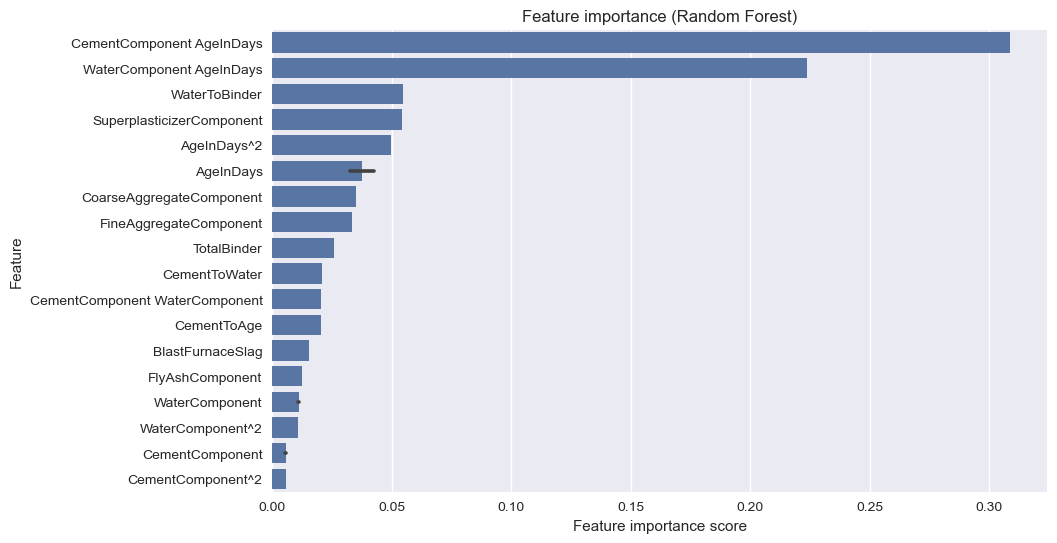


Top 5 most important features:
CementComponent AgeInDays: 0.3089
WaterComponent AgeInDays: 0.2238
WaterToBinder: 0.0547
SuperplasticizerComponent: 0.0543
AgeInDays^2: 0.0497

Random Forest Model Details:
Number of features used: 21
Out-of-bag score: Not available (oob_score=false)


In [56]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,  # Use X_final which has engineered features
    'Importance': rf_random.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature importance (Random Forest)')
plt.xlabel('Feature importance score')
plt.show()

# Show top 5 most important features
print(f"\nTop 5 most important features:")
for i, row in feature_importance.head().iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Additional Random Forest specific metrics
print(f"\nRandom Forest Model Details:")
print(f"Number of features used: {rf_random.best_estimator_.n_features_in_}")
print(f"Out-of-bag score: {rf_random.best_estimator_.oob_score_ if hasattr(rf_random.best_estimator_, 'oob_score_') else 'Not available (oob_score=false)'}")

Random Forest Model Analysis:
Number of trees: 300
Average tree depth (sample of 10 trees): 10.00
Max tree depth (sample): 10
Min tree depth (sample): 10


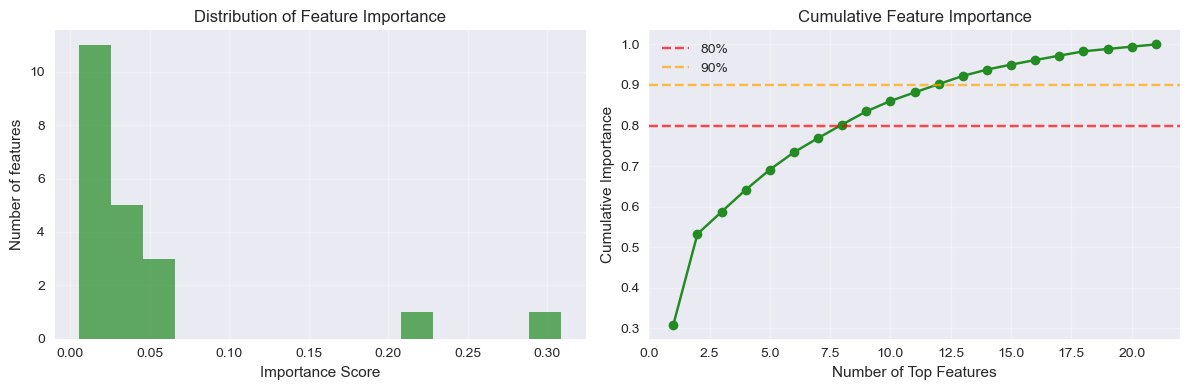


Features contributing to 80% of importance: 8
Features contributing to 90% of importance: 12


In [57]:
# Random Forest specific analysis
print("Random Forest Model Analysis:")
print(f"Number of trees: {rf_random.best_estimator_.n_estimators}")

# Get tree depths (sample from first few trees)
tree_depths = []
for i in range(min(10, rf_random.best_estimator_.n_estimators)):
    tree_depths.append(rf_random.best_estimator_.estimators_[i].tree_.max_depth)

print(f"Average tree depth (sample of 10 trees): {np.mean(tree_depths):.2f}")
print(f"Max tree depth (sample): {max(tree_depths)}")
print(f"Min tree depth (sample): {min(tree_depths)}")

# Feature importance distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(rf_random.best_estimator_.feature_importances_, bins=15, alpha=0.7, color='forestgreen')
plt.title("Distribution of Feature Importance")
plt.xlabel('Importance Score')
plt.ylabel('Number of features')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumulative_importance = np.cumsum(feature_importance['Importance'].values)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-', color='forestgreen')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance')
plt.grid(True, alpha=0.3)

# Add horizontal lines for reference
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
plt.legend()

plt.tight_layout()
plt.show()

# Find how many features contribute to 80% and 90% of importance
feature_80 = np.argmax(cumulative_importance >= 0.8) + 1
feature_90 = np.argmax(cumulative_importance >= 0.9) + 1
print(f"\nFeatures contributing to 80% of importance: {feature_80}")
print(f"Features contributing to 90% of importance: {feature_90}")

In [58]:
# Training the model on 100% data after done with initial training and testing
rf_random.best_estimator_.fit(X_final, y)

RandomForestRegressor(max_depth=10, max_features=0.8, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=300, n_jobs=-1,
                      random_state=42)

## 8. Make Predictions on Test Set

Use the trained model to make predictions on the test dataset.

In [59]:
# Make predictions on the test set
test_predictions = rf_random.best_estimator_.predict(X_test_final)

print(f"Test prediction shape: {test_predictions.shape}")
print(f"\nFirst 10 test predictions:")
print(test_predictions[:10])

print(f"\nTest predictions statistics:")
print(f"Mean: {test_predictions.mean():.4f}")
print(f"Median: {np.median(test_predictions):.4f}")
print(f"Std: {test_predictions.std():.4f}")
print(f"Min: {test_predictions.min():.4f}")
print(f"Max: {test_predictions.max():.4f}")

# Check for any negative predictions (should not happen for concrete strength)
negative_predictions = (test_predictions < 0).sum()
print(f"\nNumber of negative predictions: {negative_predictions}")
if negative_predictions > 0:
    print("Warning: Random Forest produced negative predictions")

Test prediction shape: (3605,)

First 10 test predictions:
[48.35119435 19.26562323 33.96473392 48.03434825 32.56499753 43.2796384
 32.44026436 25.86900981 47.1216996  33.75846394]

Test predictions statistics:
Mean: 35.3971
Median: 37.1927
Std: 11.3320
Min: 11.7904
Max: 66.6905

Number of negative predictions: 0


## 9. Save Predictions to CSV File

Create a submission dataframe with predictions and save it to 'submission.csv' using pandas.

In [60]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Strength': test_predictions
})

print("Submission dataframe created:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

# Verify the format matched sample submission
print(f"\nSample submission shape: {sample_submssion.shape}")
print(f"Columns match: {list(submission.columns) == list(sample_submssion.columns)}")

Submission dataframe created:
     id   Strength
0  5407  48.351194
1  5408  19.265623
2  5409  33.964734
3  5410  48.034348
4  5411  32.564998
5  5412  43.279638
6  5413  32.440264
7  5414  25.869010
8  5415  47.121700
9  5416  33.758464

Submission shape: (3605, 2)

Sample submission shape: (3605, 2)
Columns match: True


In [61]:
# Save to a CSV file
submission.to_csv('submission_rf_2.csv', index=False)

print("Predictions saved to 'submission_rf_2.csv' successfully!")

# Verify the file was created and read it back
verification = pd.read_csv('submission_rf_2.csv')
print(f"\nVerification - File shape: {verification.shape}")
print("First 5 rows of saved file:")
print(verification.head())
print("\nLast 5 rows of saved file:")
print(verification.tail())

Predictions saved to 'submission_rf_2.csv' successfully!

Verification - File shape: (3605, 2)
First 5 rows of saved file:
     id   Strength
0  5407  48.351194
1  5408  19.265623
2  5409  33.964734
3  5410  48.034348
4  5411  32.564998

Last 5 rows of saved file:
        id   Strength
3600  9007  34.993526
3601  9008  37.322250
3602  9009  39.583323
3603  9010  33.088912
3604  9011  22.836861
